# Clean Data
Authors: Connor Finn, Riley Greene <br>
Date: March 2, 2020


At this point, we have collected data on all the teams which competed in our list of NCAA tournament baskeball games.
Now, it is important that we reorganize this data into a useful framework for machine learning analysis.

## Schema
We would like to reorganize our data into a framework which resembles the shown schema

<IPython.core.display.Javascript object>


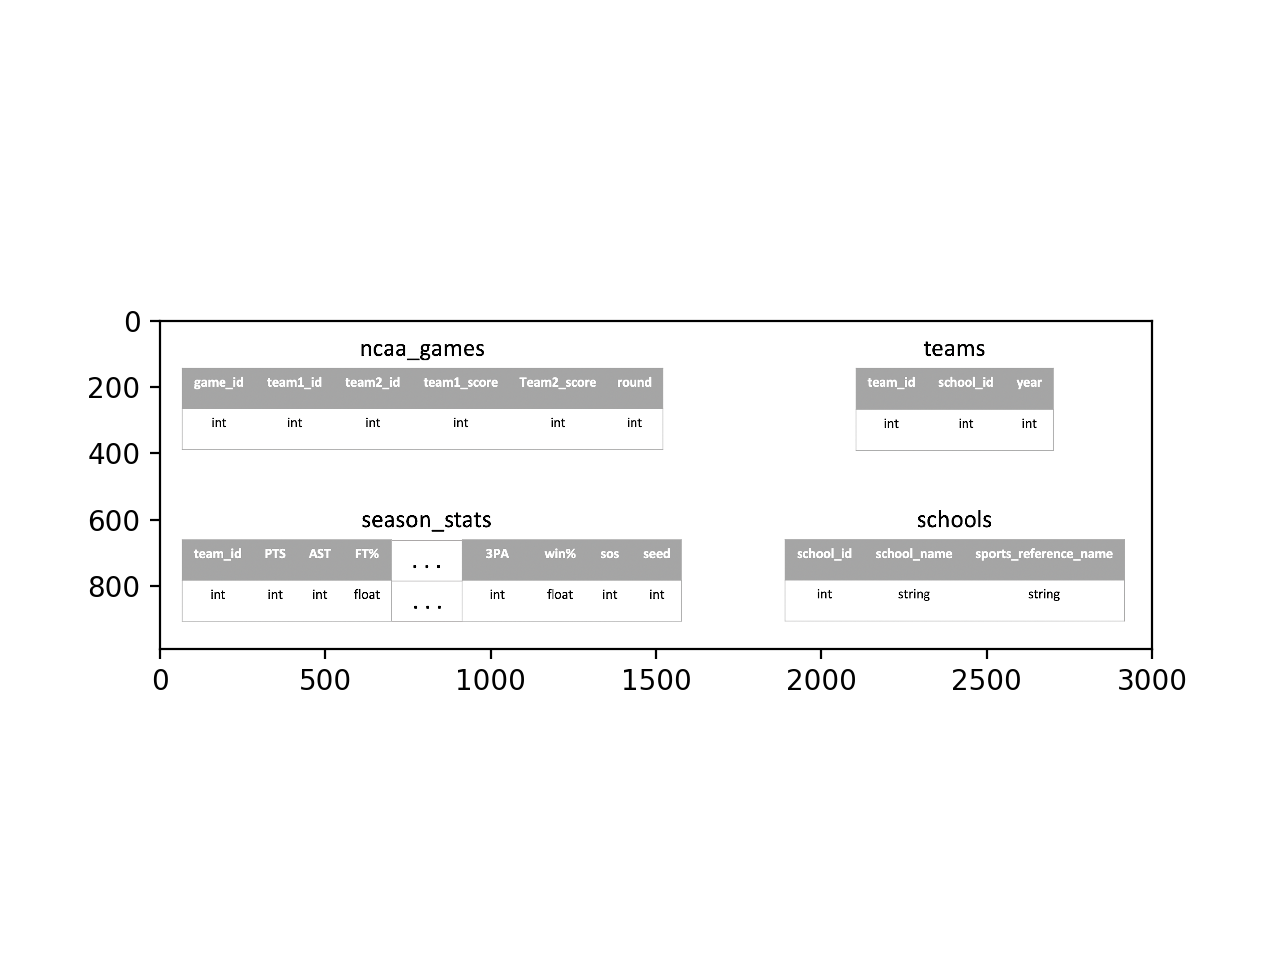

In [178]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("schema.png")
plt.imshow(image)
plt.show()

## Read in our data

In [179]:
import pandas as pd
season_data = pd.read_csv("collected_data/season_data.csv")
more_team_data = pd.read_csv("collected_data/more_team_data.csv")
ncaa_short = pd.read_csv("collected_data/ncaa_short.csv")

### We can first get a sense of what the data looks like. 
* Season_data is a data set of statistics for a given team
    + teams are distinguished by the given id and the year
    + the id is unique to school but not season


In [180]:
season_data.describe()

,G,MP,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,...,TRB,AST,STL,BLK,TOV,PF,PTS,PTS/G,Team_ID,Date
count,674.000000,656.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,...,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,34.847181,7028.358232,903.544510,1974.548961,0.457424,663.152819,1306.971810,0.507782,240.391691,667.577151,...,1242.977745,495.264095,233.535608,137.468843,425.669139,617.350148,2576.286350,73.887537,1294.651335,2013.535608
std,1.841917,368.077935,91.877536,167.085554,0.021913,81.639144,151.012209,0.028389,49.973107,115.942385,...,126.566973,70.451832,47.083998,40.820810,52.668681,66.452783,242.878876,5.139888,105.025456,2.861759
min,30.000000,6025.000000,671.000000,1425.000000,0.380000,448.000000,878.000000,0.426000,124.000000,394.000000,...,796.000000,304.000000,118.000000,46.000000,258.000000,457.000000,1926.000000,59.300000,1103.000000,2009.000000
25%,34.000000,6800.000000,837.000000,1865.250000,0.443000,606.250000,1209.000000,0.488000,203.000000,580.500000,...,1153.500000,446.250000,201.000000,108.000000,390.000000,571.250000,2409.750000,70.100000,1211.000000,2011.000000
50%,35.000000,7025.000000,899.000000,1967.500000,0.457000,657.000000,1302.500000,0.507000,236.000000,659.500000,...,1243.000000,489.500000,231.000000,134.000000,423.000000,612.500000,2569.000000,73.600000,1294.500000,2014.000000
75%,36.000000,7231.750000,963.750000,2077.750000,0.472000,716.750000,1394.750000,0.525000,273.000000,745.750000,...,1328.750000,540.750000,260.750000,162.000000,458.750000,661.000000,2738.500000,77.400000,1391.500000,2016.000000
max,41.000000,8350.000000,1235.000000,2633.000000,0.522000,1011.000000,1893.000000,0.592000,464.000000,1158.000000,...,1748.000000,771.000000,430.000000,344.000000,583.000000,828.000000,3463.000000,89.800000,1463.000000,2018.000000


* Like season_data, more_team_data is a data set of statistics for a given team
    + teams are distinguished by the given id and the year
    + the id is unique to school but not season

In [181]:
more_team_data.describe()

,Rk,W-L%,W-L%.1,SRS,SOS,PTS,PTS.1,AP Pre,AP High,AP Final,Seed
count,2600.000000,2600.000000,2590.000000,2591.000000,2591.000000,2599.000000,2599.000000,301.000000,544.000000,275.000000,736.000000
mean,6.493846,0.564278,0.551071,3.343030,1.459128,71.214275,68.439631,13.039867,11.597426,12.989091,8.728261
std,3.451522,0.164415,0.206160,9.648519,5.571433,5.586874,5.240085,7.244198,7.509949,7.224999,4.662143
min,1.000000,0.065000,0.000000,-29.500000,-12.710000,52.600000,51.200000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,0.455000,0.389000,-3.695000,-3.165000,67.400000,64.900000,7.000000,5.000000,7.000000,5.000000
50%,6.000000,0.576000,0.556000,3.310000,1.050000,71.300000,68.300000,13.000000,11.000000,13.000000,9.000000
75%,9.000000,0.686000,0.714000,10.700000,6.675000,75.000000,71.900000,19.000000,18.000000,19.000000,13.000000
max,12.000000,0.974000,1.000000,28.720000,12.790000,89.800000,90.900000,25.000000,25.000000,25.000000,16.000000


* ncaa_short is a dataframe of games which occured in the ncaa tournament
    + games have a Winning team ID, and a losing team ID, and a Season
    + These Id's are unique to school, but not season.

In [182]:
ncaa_short.describe()

,Unnamed: 0,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,1851.500000,2013.536145,138.993976,1291.263554,74.882530,1295.033133,63.480422,0.057229
std,191.824573,2.861597,4.225181,101.213936,10.516441,105.058838,10.066127,0.268579
min,1520.000000,2009.000000,134.000000,1104.000000,47.000000,1103.000000,34.000000,0.000000
25%,1685.750000,2011.000000,136.000000,1211.000000,68.000000,1211.000000,57.000000,0.000000
50%,1851.500000,2014.000000,137.000000,1277.000000,75.000000,1295.000000,63.000000,0.000000
75%,2017.250000,2016.000000,139.000000,1387.000000,81.250000,1392.250000,70.000000,0.000000
max,2183.000000,2018.000000,154.000000,1463.000000,105.000000,1463.000000,96.000000,2.000000


### Start cleaning the data.
* Fist step is to merge more_team_data and season_data on the school, and the year

In [183]:
# Prepare the dataframes for the merge
more_team_data = more_team_data.rename( columns = { "Season": "Date" , "team": 'Team' })
more_team_data['Date'] = more_team_data['Date'].map(lambda x: int(x[:2] + x[5:7]) )
season_data["Date"] = season_data["Date"].map(lambda x: int(x))

In [184]:
# execute the merge
season_stats = pd.merge(season_data, more_team_data, on=[ 'Team' , 'Date' ] , how = 'left')

In [185]:
# rename the team_id to school_id
season_stats = season_stats.rename( columns = {'Team_ID': 'school_id'})

#### Generate a new, team_id: unique to year and school

In [186]:
initial_value = 100001
season_stats['team_id'] = range(initial_value, len(season_stats) +initial_value)


#### Create the Teams DataFrame

In [187]:
teams = season_stats[["team_id" , 'school_id' , "Date"]].copy()

In [188]:
teams.head()

,team_id,school_id,Date
0,100001,1287.0,2009
1,100002,1163.0,2009
2,100003,1181.0,2009
3,100004,1211.0,2009
4,100005,1261.0,2009


#### Create the Schools DataFrame
At this point, we decided that the school_id and sports-reference-name was sufficient.

In [189]:
schools = season_stats[['school_id' , 'Team'  ]]

In [190]:
# This will get it closer to the Schema
schools = schools.rename(columns = {'Team': "sports_reference_name"})
schools.head()

,school_id,sports_reference_name
0,1287.0,morehead-state
1,1163.0,connecticut
2,1181.0,duke
3,1211.0,gonzaga
4,1261.0,louisiana-state


#### Create the ncaa_games DataFrame

In [191]:
# Get the winner TeamID
ncaa_games  = pd.merge(ncaa_short, teams, left_on=[ 'WTeamID' , 'Season' ] , right_on=[ "school_id", "Date" ] ,how = 'left')
ncaa_games = ncaa_games.drop(['WTeamID' , 'school_id' , "WLoc" , "NumOT"] , axis = 1)
ncaa_games = ncaa_games.rename(columns = {'team_id': "team_1_id"})


In [192]:
# Get the Loser Team ID
ncaa_games  = pd.merge(ncaa_games, teams, left_on=[ 'LTeamID' , 'Season' ] , right_on=[ "school_id", "Date" ] ,how = 'left')
ncaa_games = ncaa_games.drop(['LTeamID' , 'school_id' , "Date_x" , "Date_y" , "Season" , "Unnamed: 0" , "DayNum"] , axis = 1)
ncaa_games = ncaa_games.rename(columns = {'team_id': "team_2_id" , "WScore": "team_1_score" , "LScore": "team_2_score"})


In [193]:
# create the unique game_id
initial_value = 1
ncaa_games['game_id'] = range(initial_value, len(ncaa_games) +initial_value)
ncaa_games.head()

,team_1_score,team_2_score,team_1_id,team_2_id,game_id
0,58,43,100001,100034,1
1,103,47,100002,100035,2
2,86,62,100003,100036,3
3,77,64,100004,100037,4
4,75,71,100005,100038,5


#### Finalize the season_stats Dataframe

In [194]:
season_stats.columns

Index(['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS_x', 'PTS/G', 'school_id', 'Date', 'Rk', 'Conf', 'W',
       'L', 'W-L%', 'W.1', 'L.1', 'W-L%.1', 'SRS', 'SOS', 'PTS_y', 'PTS.1',
       'AP Pre', 'AP High', 'AP Final', 'NCAA Tournament', 'Seed', 'Coach(es)',
       'Unnamed: 19', 'team_id'],
      dtype='object')

In [195]:
# Lets only keep the numerical columns we care about
cols_keep = ['team_id', 'FG' , 'FGA', 'FG%', '2P' , '2PA', '2P%', '3P' , '3PA', '3P%', 'FT' , 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB' , 'AST', 'STL', 'BLK', 'TOV', 'PF',  'PTS/G','W-L%', 'SRS', 'SOS','PTS.1','Seed' ]
season_stats = season_stats[cols_keep]
season_stats = season_stats.rename(columns = {"PTS.1": "opp_PPG"})

season_stats.head()

,team_id,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,...,STL,BLK,TOV,PF,PTS/G,W-L%,SRS,SOS,opp_PPG,Seed
0,100001,865,1978,0.437,677,1413,0.479,188,565,0.333,...,239,139,557,657,69.8,0.556,-3.14,-3.61,67.0,16.0
1,100002,996,2102,0.474,831,1618,0.514,165,484,0.341,...,209,280,458,471,78.3,0.861,22.17,8.57,64.3,1.0
2,100003,971,2186,0.444,704,1420,0.496,267,766,0.349,...,311,146,454,671,77.5,0.811,20.10,9.07,65.9,2.0
3,100004,967,1982,0.488,716,1339,0.535,251,643,0.390,...,246,174,386,551,78.9,0.824,17.95,3.55,63.0,4.0
4,100005,937,2093,0.448,724,1521,0.476,213,572,0.372,...,267,212,425,609,74.8,0.771,11.87,3.27,66.2,8.0


# At this point, we should have the schema

### Do we have missing Data?


In [196]:
def check_null(df):
    """
    This function takes in a df as an argument, and returns the null values by column
    """
    null_columns=df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum()
    

In [197]:
check_null(ncaa_games)

Series([], dtype: float64)

In [198]:
check_null(season_stats)

Series([], dtype: float64)

In [199]:
check_null(teams)

Series([], dtype: float64)

In [200]:
check_null(schools)

Series([], dtype: float64)

There is no missing data in our cleaned dataframes.

### Shuffle team1 and team2 in the ncaa_games df to eliminate selection bias

As of now, team_1 will always win. We don't want any inherant biases in our data set, so we will randomly shuffle team_1 and team_2

In [201]:
%%capture
def shuffle(row):
    """
    This function will randomly shuffle which team 
    is team 1.  Origionally, the winner is always team 1
    """
    from random import choice
    val = choice([0 , 1])
    if val ==0:
        # everything stays the same
        pass
    else:
        # switch the teams
        ph1 = row["team_1_id"]
        ph2 = row["team_1_score"]
        row["team_1_score"] = row["team_2_score"] 
        row["team_1_id"] = row["team_2_id"]
        row["team_2_id"] = ph1
        row["team_2_score"] = ph2
        return row

ncaa_games.apply(shuffle , axis = 1 )

Save our data for future use

In [202]:
import os

# make folder
if not os.path.exists('./clean_data'):
    os.mkdir('./clean_data')

# write our df's
season_stats.to_csv('clean_data/season_stats.csv' , index = False)
teams.to_csv('clean_data/teams.csv' , index = False)
schools.to_csv('clean_data/schools.csv' , index = False)
ncaa_games.to_csv('clean_data/ncaa_games.csv' , index = False)